In [1]:
import csv
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
from IPython.display import Image
from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import os, os.path

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from patsy import cr
from patsy import dmatrix 

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import mean_squared_error
from math import sqrt


import sys
# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_core as rcp

start = time.time()

# Directories

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/" + \
           "remote_sensing/01_NDVI_TS/no_ID/Grant/No_EVI/Grant_10_cloud/Grant_2017/"

In [3]:
output_dir = data_dir
plot_dir_base = data_dir + "plots/"

# Data reading

In [4]:
file_names = ["Grant_2017_TS.csv"]
file_N = file_names[0]
a_df = pd.read_csv(data_dir + file_N)

# The following columns do not exist in the old data
a_df['CovrCrp'] = "NA" 
a_df['DataSrc'] = "NA" 

a_df = rc.initial_clean_NDVI(a_df)
a_df.head(2)

,Acres,B2,B3,B4,B8,CropGrp,CropTyp,ExctAcr,IntlSrD,Irrigtn,...,Shap_Ar,Shp_Lng,Source,TRS,county,doy,year,geo,CovrCrp,DataSrc
0,36,0.092407,0.070650,0.071444,0.109662,Herb,Mint,35.813572,2003/07/01 00:00:00,Drip,...,144932.383795,1572.482519,WSDA,T16R27E23,Grant,62.0,2017.0,"{""type"":""Polygon"",""coordinates"":[[[-119.404844...",NA,NA
1,36,0.105605,0.107085,0.075052,0.436749,Herb,Mint,35.813572,2003/07/01 00:00:00,Drip,...,144932.383795,1572.482519,WSDA,T16R27E23,Grant,119.0,2017.0,"{""type"":""Polygon"",""coordinates"":[[[-119.404844...",NA,NA


In [5]:
an_EE_TS = a_df.copy()
an_EE_TS = an_EE_TS.iloc[1:1000]

# an_EE_TS = rc.initial_clean_NDVI(an_EE_TS)

### List of unique polygons
polygon_list = an_EE_TS['geo'].unique()
print(len(polygon_list))

output_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
                  'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
                  'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo',
                  'peak_Doy', 'peak_value']

all_polygons_and_their_peaks = pd.DataFrame(data=None, 
                                            index=np.arange(3*len(an_EE_TS)), 
                                            columns=output_columns)

double_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
                  'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
                  'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo']

double_polygons = pd.DataFrame(data=None, 
                               index=np.arange(2*len(an_EE_TS)), 
                               columns=double_columns)

32


In [6]:
pointer = 0
double_pointer = 0
counter = 0

a_poly = polygon_list[0]

counter += 1
curr_field = an_EE_TS[an_EE_TS['geo']==a_poly]

year = int(curr_field['year'].unique())
plant = curr_field['CropTyp'].unique()[0]

plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")

county = curr_field['county'].unique()[0]
TRS = curr_field['TRS'].unique()[0]

### 
###  There is a chance that a polygon is repeated twice?
###

X = curr_field['doy']
y = curr_field['NDVI']
freedom_df = 10
#############################################
###
###             Smoothen
###
#############################################

# Generate spline basis with "freedom_df" degrees of freedom
x_basis = cr(X, df=freedom_df, constraints='center')

# Fit model to the data
model = LinearRegression().fit(x_basis, y)

# Get estimates
y_predic = model.predict(x_basis)

In [7]:
X_const = np.arange(start=1, stop=365, step=14)
x_const_basis = cr(X_const, df=(freedom_df), constraints='center')
x_const_basis = pd.DataFrame(x_const_basis)
y_const_pred = model.predict(x_const_basis)

# Natural Cubic Spline

In [8]:
train_y = y
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train, df = 10)", {"train": X}, return_type='dataframe')

fit3 = sm.GLM(train_y, transformed_x3).fit()

# Prediction on validation set
pred3 = fit3.predict(dmatrix("cr(valid, df=10)", {"valid": X}, return_type='dataframe'))

# Calculating RMSE value
rms = sqrt(mean_squared_error(train_y, pred3))
print(rms)

0.06590564990535319


In [13]:
pred_constant = fit3.predict(dmatrix("cr(valid, df=10)", {"valid": X_const}, return_type='dataframe'))

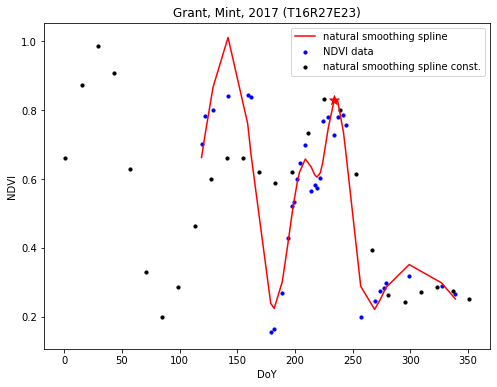

In [16]:
LA = 5
de = 0.1
peaks_spline = rc.peakdetect(pred3, lookahead=LA, delta=de)
max_peaks =  peaks_spline[0]
peaks_spline = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)
# print(peaks_spline)
DoYs_series = pd.Series(peaks_spline[0])
peaks_series = pd.Series(peaks_spline[1])

peaks_spline_const = rc.peakdetect(y_const_pred, lookahead = 10, delta=0)
max_peaks_const =  peaks_spline_const[0]
peaks_spline_const = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks_const, doy_vect=X_const)
# print(peaks_spline)
DoYs_series_const = pd.Series(peaks_spline_const[0])
peaks_series_const = pd.Series(peaks_spline_const[1])

##############
############## plot
##############

plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"
# sb.set();
fig, ax = plt.subplots(figsize=(8,6));
# ax.plot(X, y, label="NDVI data");
ax.scatter(X, y, s=10, c='b', marker='o', label="NDVI data");

ax.plot(X, pred3, 'r', label="natural smoothing spline")
# ax.scatter(X, y_predic, s=10, c='r', marker='o', label="smoothing spline");

# ax.plot(X_const, y_const_pred, 'g', label="smoothing spline const.")
ax.scatter(X_const, pred_constant, s=10, c='k', marker='o', label="natural smoothing spline const.");

ax.scatter(DoYs_series, peaks_series, s=100, c='r', marker='*');
ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='NDVI')
ax.legend(loc="best");

# sb.despine() # removes top and right axis/frame (when we have not done sb.set(); and background is white)
fig_name = "/Users/hn/Desktop/" + 'natural_df_' + str(freedom_df) + "_LA_" + str(LA) + '_delta_' + str(de) + '.png'
plt.savefig(fname = fig_name, \
            dpi=300, 
            bbox_inches='tight')

In [10]:
rc.my_peakdetect(y_axis=pred3, x_axis=X, delta=.1)

[[[142.0, 1.0115540379700318], [234.0, 0.8291076923998333]],
 [[182.0, 0.22377758577208162], [269.0, 0.22087757064816366]]]

In [17]:
LA = 5
de = 0.1
peaks_spline = rc.peakdetect(pred3, lookahead=LA, delta=0.)
peaks_spline

[[[3, 1.0115540379700318], [14, 0.6581392846690826], [21, 0.8291076923998333]],
 [[7, 0.22377758577208162],
  [17, 0.6054110655132637],
  [26, 0.22087757064816366]]]

In [18]:
pred3

1     0.662407
2     0.727148
3     0.867011
4     1.011554
5     0.761589
6     0.669022
7     0.238571
8     0.223778
9     0.301327
10    0.414849
11    0.487472
12    0.532564
13    0.590311
14    0.620457
15    0.658139
16    0.635449
17    0.612996
18    0.605411
19    0.618374
20    0.646756
21    0.750912
22    0.829108
23    0.826930
24    0.736749
25    0.679881
26    0.287987
27    0.220878
28    0.249980
29    0.271453
30    0.284953
31    0.351157
33    0.298152
34    0.251277
dtype: float64

In [ ]:
x_basis

In [ ]:
pointer = 0
double_pointer = 0
counter = 0

for a_poly in polygon_list:
    if (counter%1000 == 0):
        print (counter)
    counter += 1
    curr_field = an_EE_TS[an_EE_TS['geo']==a_poly]

    year = int(curr_field['year'].unique())
    plant = curr_field['CropTyp'].unique()[0]
    
    plant = plant.replace("/", "_")
    plant = plant.replace(",", "_")
    plant = plant.replace(" ", "_")
    
    county = curr_field['county'].unique()[0]
    TRS = curr_field['TRS'].unique()[0]

    ### 
    ###  There is a chance that a polygon is repeated twice?
    ###

    X = curr_field['doy']
    y = curr_field['NDVI']
    freedom_df = 10
    #############################################
    ###
    ###             Smoothen
    ###
    #############################################

    # Generate spline basis with "freedom_df" degrees of freedom
    x_basis = cr(X, df=freedom_df, constraints='center')

    # Fit model to the data
    model = LinearRegression().fit(x_basis, y)

    # Get estimates
    y_predic = model.predict(x_basis)


    #############################################
    ###
    ###             find peaks
    ###
    #############################################
    # peaks_LWLS_1 = peakdetect(LWLS_1[:, 1], lookahead = 10, delta=0)
    # max_peaks = peaks_LWLS_1[0]
    # peaks_LWLS_1 = form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)

    peaks_spline = rc.peakdetect(y_predic, lookahead = 10, delta=0)
    max_peaks =  peaks_spline[0]
    peaks_spline = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)
    # print(peaks_spline)
    DoYs_series = pd.Series(peaks_spline[0])
    peaks_series = pd.Series(peaks_spline[1])

    peak_df = pd.DataFrame({ 
                       'peak_Doy': DoYs_series,
                       'peak_value': peaks_series
                      }) 


    WSDA_df = rc.keep_WSDA_columns(curr_field)
    WSDA_df = WSDA_df.drop_duplicates()
    
    if (len(peak_df)>0):
        WSDA_df = pd.concat([WSDA_df]*peak_df.shape[0]).reset_index()
        # WSDA_df = pd.concat([WSDA_df, peak_df], axis=1, ignore_index=True)
        WSDA_df = WSDA_df.join(peak_df)
        if ("index" in WSDA_df.columns):
            WSDA_df = WSDA_df.drop(columns=['index'])

        # all_polygons_and_their_peaks = all_polygons_and_their_peaks.append(WSDA_df, sort=False)

        """
        copy the .values. Otherwise the index inconsistency between
        WSDA_df and all_poly... will prevent the copying.
        """
        all_polygons_and_their_peaks.iloc[pointer:(pointer + len(WSDA_df))] = WSDA_df.values
        #
        #  if we have double peaks add them to the double_polygons
        #
        if (len(WSDA_df) == 2):
            print(plant, county, year, counter)
            WSDA_df = WSDA_df.drop(columns=['peak_Doy', 'peak_value'])
            WSDA_df = WSDA_df.drop_duplicates()
            double_polygons.iloc[double_pointer:(double_pointer + len(WSDA_df))] = WSDA_df.values
            double_pointer += len(WSDA_df)

        pointer += len(WSDA_df)
        
        #############################################
        ###
        ###             plot
        ###
        #############################################
        sub_out = "/" + plant + "/"
        plot_path = plot_dir_base + sub_out
        os.makedirs(plot_path, exist_ok=True)
        if (len(os.listdir(plot_path))<100):
            plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"
            sb.set();
            fig, ax = plt.subplots(figsize=(8,6));
            ax.plot(X, y, label="NDVI data");
            ax.plot(X, y_predic, 'r', label="smoothing spline result")
            ax.scatter(DoYs_series, peaks_series, s=100, c='g', marker='*');
            ax.set_title(plot_title);
            ax.set(xlabel='DoY', ylabel='NDVI')
            ax.legend(loc="best");

            fig_name = plot_path + county + "_" + plant + "_" + str(year) + "_" + str(counter) + '.png'
            plt.savefig(fname = fig_name, \
                        dpi=500, 
                        bbox_inches='tight')
            del(plot_path, sub_out, county, plant, year)
            plt.close()

        # to make sure the reference by address thing 
        # will not cause any problem.
    del(WSDA_df)

all_polygons_and_their_peaks = all_polygons_and_their_peaks[0:(pointer+1)]
double_polygons = double_polygons[0:(double_pointer+1)]

out_name = output_dir + 'all_polygons_and_their_peaks.csv'
all_polygons_and_their_peaks.to_csv(out_name, index = False)

out_name = output_dir + 'double_polygons.csv'
double_polygons.to_csv(out_name, index = False)

In [ ]:
x_axis, y_axis = rc._datacheck_peakdetect(X, pred3)
lookahead=6
delta=0

In [ ]:
max_peaks = []
min_peaks = []
dump = []
# store data length for later use
length = len(y_axis)
mn, mx = np.Inf, -np.Inf

In [ ]:
index = 2
x = x_axis[index]
y = y_axis[index]
if y > mx:
    mx = y
    mxpos = x
if y < mn:
    mn = y
    mnpos = x

#### look for max ####
if y < mx-delta and mx != np.Inf:
    # Maxima peak candidate found
    # look ahead in signal to ensure that this is a peak and not jitter
    if y_axis[index:index+lookahead].max() < mx:
        max_peaks.append([mxpos, mx])
        dump.append(True)

        # set algorithm to only find minima now
        mx = np.Inf
        mn = np.Inf

if y > mn+delta and mn != -np.Inf:
    if y_axis[index:index+lookahead].min() > mn:
        min_peaks.append([mnpos, mn])
        dump.append(False)
        mn = -np.Inf
        mx = -np.Inf

In [ ]:
mx